# Module 5 Final Project

Student name: **Cynthia Pedrasa**  
Student pace: **self paced**  
Scheduled project review date/time:  **Mon, Jun 15, 2020 10:00am - 11:00am (EDT)**  
Instructor name: **Jeff Herman**  
Blog post URL:  https://cpedrasa.github.io/exploratory_data_analysis

## Table of contents

Data Science Framework  

**Part I** [Obtain Data, Scrub Data, Data Exploration](https://github.com/cpedrasa/dsc-mod-5-project-online-ds-sp-000/blob/master/Part_1_Data_Preprocessing.ipynb)  

**Part II** [Evaluate Algorithms,  Train/Test, Evaluation Metrics, Tuning](https://github.com/cpedrasa/dsc-mod-5-project-online-ds-sp-000/blob/master/Part_2_Model_Evaluation.ipynb)  

**Part III**  
Selected Model - XGBoost Algorithms

  +    <a href="#Importing-XgBoost-Joblib">Importing XgBoost Joblib</a>
  +    <a href="#Feature-Selection">Feature Selection</a>   
  +    <a href="#XgBoost-Tuning">XgBoost Tuning</a>    
  +    <a href="#XgBoost-Performance-Metrics">XgBoost Performance Metrics</a>  



In [1]:
#Import Libraries
import pandas as pd
from pandas import set_option
import pickle
import time
import numpy as np
from numpy import mean
from numpy import std
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt # plotting library for Python
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import pyodbc
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import warnings
warnings.filterwarnings('ignore')
import scipy as sp

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score,  GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import make_classification
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier



from xgboost import plot_tree
from matplotlib.pylab import rcParams

Using TensorFlow backend.


In [2]:
#Create functions to load data, split train & test data and time execution

def load_data(file_name):   
    import pandas as pd
    df = pd.read_csv(file_name)
    y = df.readmitted
    X = df.drop(['readmitted'], axis = 1)
    return X, y

def train_test_dist(X, y):
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
def split_train_test(X, y):
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify = y )
    return X_train, X_test, y_train, y_test 

start = time.time()
def exec_time():
    execution_time = time.time() - start
    print('Execution time', time.strftime("%H:%M:%S", time.gmtime(execution_time)))

exec_time()

#Calculate prevalence
def calc_prevalence(y_test):
    return (sum(y_test)/len(y_test))
#Calculate specificity
def calc_specificity(y_test, predictions, thresh):
    # calculates specificity
    return sum((predictions < thresh) & (y_test == 0)) /sum(y_test ==0)

#Calculate and print scores        
def print_scores(y_test, y_pred):
    from sklearn.metrics import accuracy_score 
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import mean_squared_error  
    from sklearn.metrics import r2_score
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import auc
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_curve
    from sklearn.metrics import precision_score       
    print("Accuracy: {}".format((accuracy_score(y_test, y_pred).round(decimals=4)*100)),'%')
    print("Precision: {}".format(precision_score(y_test, y_pred)))
    print("Recall: {}".format(recall_score(y_test, y_pred)))
    print("F1-score: {}".format(f1_score(y_test, y_pred)))
    print("R2: {}".format(r2_score(y_test, y_pred)))
    print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
    print("Prevalence: {}".format(calc_prevalence(y_pred)))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.5)))
    print('---------------------------------------------------------------------')
    print('\n','Classification Report:')
    print(classification_report(y_test, y_pred, target_names = ['NO', 'YES']))
    print('---------------------------------------------------------------------')
    # Confusion matrix plot   
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

#plot ROC curve
def plot_roc_curve(y_test, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    auc = roc_auc_score(y_test, model_probs) 
    fpr, tpr, _ = roc_curve(y_test, model_probs)
    print('ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label = 'ROC AUC: %.3f' % roc_auc_score(y_test, model_probs).round(decimals=3))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', alpha=.8)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xticks(np.arange(0,1.1,0.1))
    plt.yticks(np.arange(0,1.1,0.1))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();
    
# plot the Precision-Recall Curve
def plot_pr_curve(y_test, y_pred, model_probs, lblname):
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import auc
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    f1, pr_auc = f1_score(y_test, y_pred), auc(recall, precision)
    print('f1=%.3f PR AUC=%.3f' % (f1, pr_auc))
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill],color='red', linestyle='--', label='Random') 
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    plt.plot(recall, precision, marker='.', label=  'PR AUC: %.3f' % auc(recall, precision).round(decimals=3))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
      # show the legend
    plt.legend()
      # show the plot
    plt.show()
    

#Calculate scores at 25% threshold
def print_scores_thresh(y_test, y_pred):
    print('---------------------------------------------------------------------')
    print('scores with threshold = 0.25')
    print('Accuracy: %.3f'%(accuracy_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('Recall: %.3f'%(recall_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('Precision: %.3f'%(precision_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('F1-score: %.3f'%(f1_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print('AUC: %.3f'%(roc_auc_score(y_test, (LR_probs >= 0.25).astype('int'))))
    print("Prevalence: {}".format(calc_prevalence(LR_probs >= 0.25).astype('int')))
    print("Specificity: {}".format(calc_specificity(y_test, y_pred, 0.25)))
    print('---------------------------------------------------------------------')
    print(classification_report(y_test, (LR_probs >= 0.25).astype('int'), target_names = ['NO', 'YES']))
    display(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    print('')

def print_mean_rocauc_scores(scores):
    from numpy import mean
    print('Mean ROC AUC: %.3f' % mean(scores))

Execution time 00:00:00


In [3]:
# Let's open the preprocessed dataset that we have previously saved 
with open('readmissions.pickle', "rb") as f:
    df = pickle.load(f)
y = df.readmitted
X = df.drop(['readmitted'], axis = 1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 91.49000000000001 %
Precision: 0.7142857142857143
Recall: 0.0019387359441644049
F1-score: 0.003866976024748647
R2: -0.09187009297068194
MSE: 0.0851063829787234
Prevalence: 0.00023126734505087883
Specificity: 0.9999277691502041
---------------------------------------------------------------------

 Classification Report:
              precision    recall  f1-score   support

          NO       0.91      1.00      0.96     27689
         YES       0.71      0.00      0.00      2579

    accuracy                      

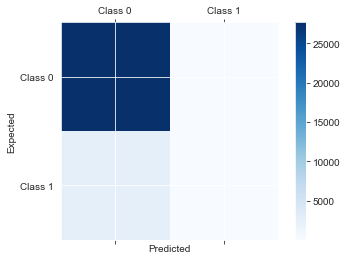

ROC AUC: 0.629


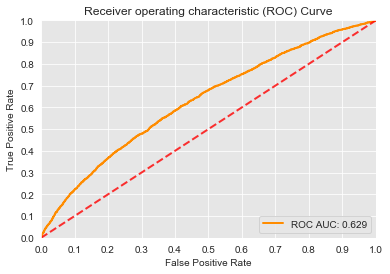

f1=0.004 PR AUC=0.141


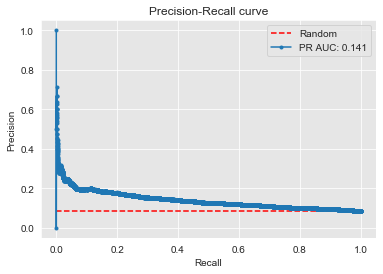

Execution time 00:00:06


In [4]:

start = time.time()

X, y = load_data('final_data.csv')                                           # load data
X_train, X_test, y_train, y_test  = split_train_test(X, y)                   # split data

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
predictions = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
XGBT_probs = model.predict_proba(X_test)[:, 1]              # predict probabilities for the positive outcome only

fpr_XGBT, tpr_XGBT, thresholds = roc_curve(y_test, XGBT_probs)              # calculate roc_auc score
XGBT_precision, XGBT_recall, _ = precision_recall_curve(y_test, XGBT_probs) # calculate pr_auc score

                                           
    #Summary report:
print_scores(y_test, y_pred)
plot_roc_curve(y_test, XGBT_probs,  'XGBT')
plot_pr_curve(y_test, y_pred, XGBT_probs, 'XGBT') 
exec_time()

In [6]:

# save model to file
pickle.dump(model, open("xgbm.pickle.dat", "wb"))


In [7]:
# load model from file
loaded_model = pickle.load(open("xgbm.pickle.dat", "rb"))



In [8]:

#Let's examine the accuracy of the predictions - the predictions compared to the true values

y_hats = model.predict(X_test)     

y_test['preds'] = y_hats

df_predictions = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)
df_predictions[df_predictions['readmitted_x']==1]
    


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted_x,number_changes,number_meds,age,number_inpatient_log,...,ICDCat1_2,ICDCat1_3,ICDCat1_4,ICDCat1_5,ICDCat1_6,ICDCat1_7,ICDCat1_8,diabetesMed_1,change_1,readmitted_y
11,7,62,0,11,7,1,1,2,65,0.0,...,0,0,0,0,0,0,1,1,1,NaN
16,4,45,4,17,8,1,0,2,55,0.0,...,0,0,0,0,0,0,0,1,1,NaN
50,4,40,1,14,9,1,0,0,55,0.0,...,0,0,0,0,0,0,1,0,0,NaN
68,2,32,3,11,9,1,0,1,55,0.0,...,0,0,0,0,0,0,0,1,0,NaN
70,7,75,2,22,7,1,0,0,75,0.0,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101334,5,63,0,9,9,1,0,2,85,0.0,...,0,0,0,0,0,0,0,1,1,NaN
101342,5,52,1,24,9,1,0,2,75,0.0,...,0,0,0,0,0,0,0,1,1,NaN
101386,4,20,0,19,9,1,0,2,75,0.0,...,0,0,0,0,0,0,0,1,1,NaN
101667,4,37,0,7,5,1,1,1,75,0.0,...,0,0,0,0,0,0,0,1,1,NaN


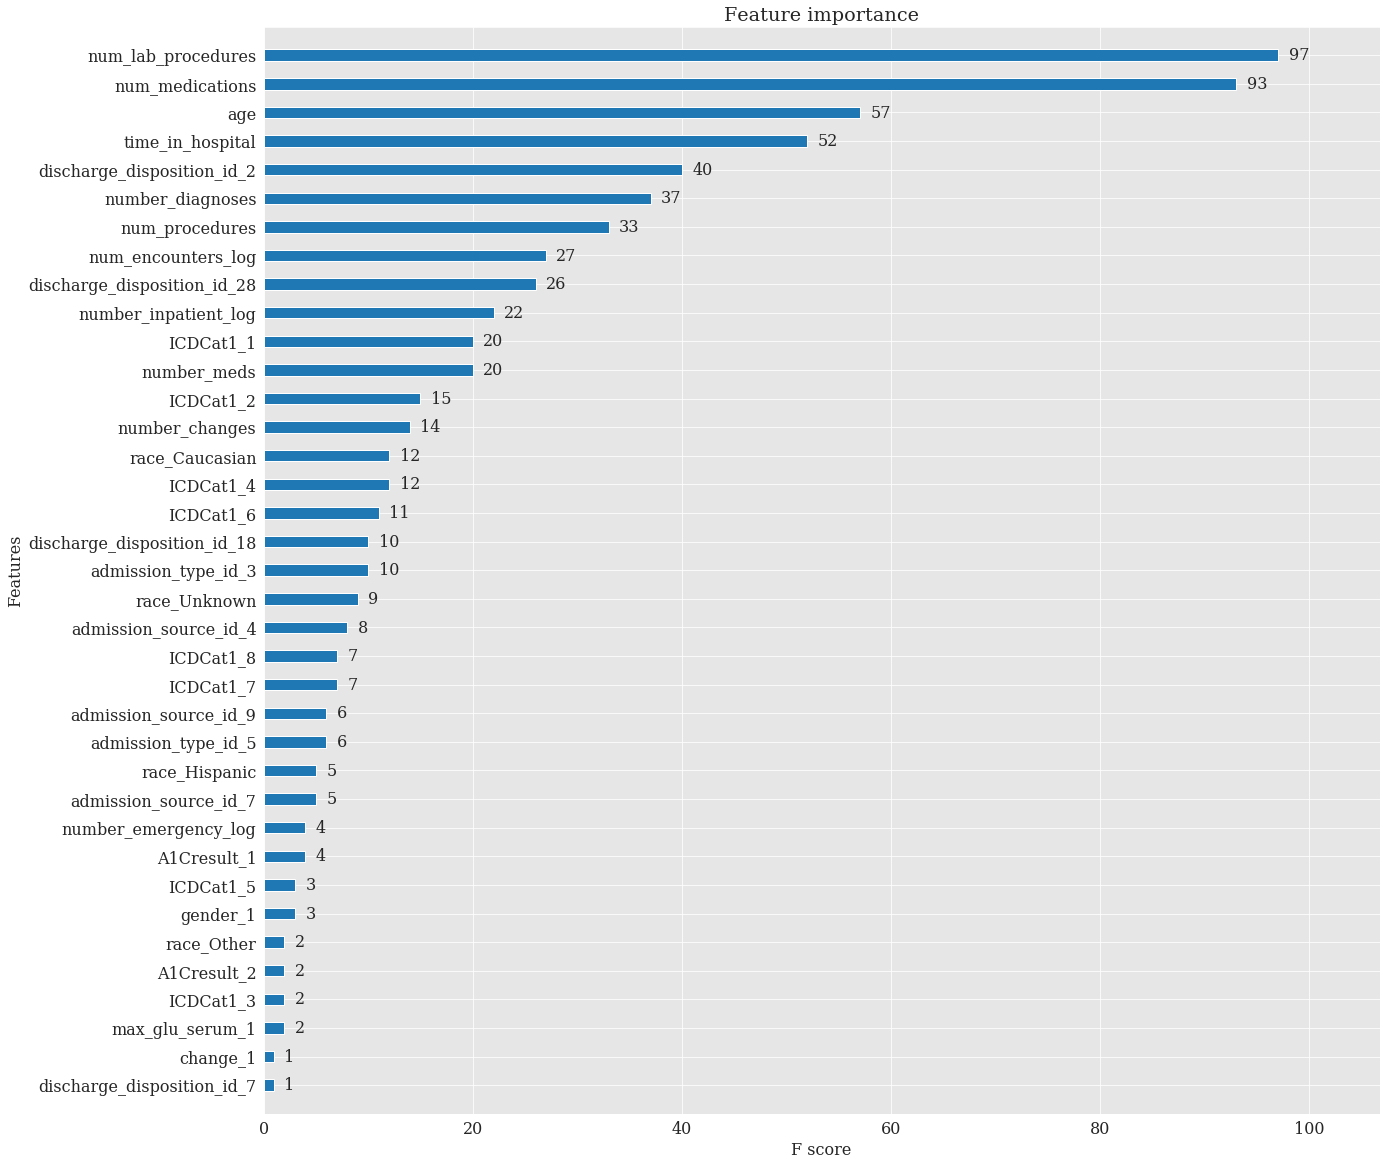

In [9]:
from xgboost import plot_importance
from matplotlib.pylab import rcParams
%matplotlib inline
# plot feature importance

plt.rcParams.update({'font.size': 16, 'font.family': 'serif'})
rcParams['figure.figsize'] = 20,20
#plt.figure(figsize=(40,60))
plot_importance(model, height=.4)
plt.show();  


In [13]:
# # ⏰ This cell may take a long time to run!
# # start = time.time()
# from xgboost import XGBClassifier


# param_grid = {
#     'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
#     'max_depth': [6],
#     'min_child_weight': [1, 2],
#     'subsample': [0.5, 0.7],
#     'n_estimators': [100]
# }
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_XGBt = GridSearchCV(model, param_grid, scoring='roc_auc', cv=cv, n_jobs=1)
# grid_XGBt.fit(X_train, y_train)

# best_XBG_params = grid_XGBt.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_XBG_params.keys()):
#     print('%s: %r' % (param_name, best_XBG_params[param_name]))

# XGBt_train_preds = grid_XGBt.predict(X_train)
# XGBt_test_preds = grid_XGBt.predict(X_test)
# training_accuracy = accuracy_score(y_train, XGBt_train_preds)
# test_accuracy = accuracy_score(y_test, XGBt_test_preds)

# print('')
# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
# print('')
# print_scores(y_test, XGBt_test_preds)
# fpr_XGBt, tpr_XGBt, thresholds = roc_curve(y_test, XGBt_test_preds)

# # exec_time()

# """Grid Search found the following optimal parameters: 
# learning_rate: 0.01
# max_depth: 6
# min_child_weight: 2
# n_estimators: 100
# subsample: 0.5
# """

In [20]:
# selected_features = ['num_lab_procedures',
#  'num_medications',
#  'age',
#  'time_in_hospital',
#  'discharge_disposition_id_2',
#  'number_diagnoses',
#  'num_procedures',
#  'num_encounters_log',
#  'discharge_disposition_id_28',
#  'number_inpatient_log',
#  'ICDCat1_1',
#  'number_meds',
#  'gender_1',
#  'race_Caucasian',
 
#  'admission_source_id_7',
#  'A1Cresult_2',
#  'admission_type_id_3',
#  'ICDCat1_1',
 
#  'change_1',
#  'A1Cresult_1',
#  'number_changes',   
#  'ICDCat1_3',
#  'admission_type_id_5']
 
# X = df[selected_features]
# y = df['readmitted']

# #define X and y 
# X = df.drop(['readmitted'], axis = 1)
# y = df.readmitted



# X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# df = pd.merge(X,y)
# df.head()

In [ ]:
Features
